# Наивный Байес и спам
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW10] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict, Counter
import matplotlib
import copy
import spacy
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from typing import NoReturn, List
import re
from string import punctuation

In [2]:
import re
def read_dataset(filename):
    file = open(filename, encoding="utf-8")
    x = []
    y = []
    for line in file:
        cl, sms = re.split("^(ham|spam)[\t\s]+(.*)$", line)[1:3]
        x.append(sms)
        y.append(cl)
    return np.array(x, dtype=np.str), np.array(y, dtype=np.str)

In [3]:
def get_precision_recall_accuracy(y_pred, y_true):
    classes = np.unique(list(y_pred) + list(y_true))
    true_positive = dict((c, 0) for c in classes)
    true_negative = dict((c, 0) for c in classes)
    false_positive = dict((c, 0) for c in classes)
    false_negative = dict((c, 0) for c in classes)
    for c_pred, c_true in zip(y_pred, y_true):
        for c in classes:
            if c_true == c:
                if c_pred == c_true:
                    true_positive[c] = true_positive.get(c, 0) + 1
                else:
                    false_negative[c] = false_negative.get(c, 0) + 1
            else:
                if c_pred == c:
                    false_positive[c] = false_positive.get(c, 0) + 1
                else:
                    true_negative[c] = true_negative.get(c, 0) + 1
    precision = dict((c, 0 if true_positive[c] == 0 else true_positive[c] / (true_positive[c] + false_positive[c])) for c in classes)
    recall = dict((c, 0 if true_positive[c] == 0 else true_positive[c] / (true_positive[c] + false_negative[c])) for c in classes)
    accuracy = sum([true_positive[c] for c in classes]) / len(y_pred)
    return precision, recall, accuracy

def plot_precision_recall(X_train, y_train, X_test, y_test, bow_method, voc_sizes=range(4, 200, 5)):
    classes = np.unique(list(y_train) + list(y_test))
    precisions = dict([(c, []) for c in classes])
    recalls = dict([(c, []) for c in classes])
    accuracies = []
    for v in voc_sizes:
        bow = bow_method(X_train, voc_limit=v)
        X_train_transformed = bow.transform(X_train)
        X_test_transformed = bow.transform(X_test)
        classifier = NaiveBayes(0.001)
        classifier.fit(X_train_transformed, y_train)
        y_pred = classifier.predict(X_test_transformed)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in classes:
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("Vocabulary size")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(list(ys.values()))-0.01, np.max(list(ys.values()))+0.01)
        for c in ys.keys():
            plt.plot(x, ys[c], label="Class " + str(c))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(voc_sizes, recalls, "Recall")
    plot(voc_sizes, precisions, "Precision")
    plot(voc_sizes, {"":accuracies}, "Accuracy", legend=False)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
X, y = read_dataset("/content/drive/MyDrive/Colab Notebooks/ML/spam")

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=128)

### Задание 1 (3 балла)
Реализуйте классификацию методом Байеса в предположении независимости компонент `x`. При реализации следует считать, что значения каждой компоненты дискретны, а `p(x|y)` имеет мультиномиальное распределение.

#### Методы
`fit(X, y)` - оценивает параметры распределения `p(x|y)` для каждого `y`. 

`log_proba(X)` - для каждого элемента набора `X` считает логарифм вероятности отнести его к каждому классу. По теореме Байеса: `p(y|x) = p(y)p(x|y)/p(x)`. Соответственно, после логарифмирования: `log p(y|x) = log p(y) + log p(x|y) - log p(x)`. Поскольку `log p(x)` является независящей от класса `y` константой, это слагаемое никак не влияет на решение задачи максимизации. Поэтому его можно просто убрать для простоты.

In [98]:
class NaiveBayes:
    def __init__(self, alpha: float):
        """
        Parameters
        ----------
        alpha : float
            Параметр аддитивной регуляризации.
        """
        self.alpha = alpha
        self.n_classes = 2
        self.logprobs_ham = None
        self.logprobs_spam = None


    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Оценивает параметры распределения p(x|y) для каждого y.
        """
        self.classes, self.classes_count = np.unique(y, return_counts=True) 
        self.ham_log_prob = np.log(self.classes_count[0] / self.classes_count.sum())
        self.spam_log_prob = np.log(self.classes_count[1] / self.classes_count.sum())
        vocab_size = X.shape[1]

        ham_mask = y == 'ham'
        spam_mask = y == 'spam'

        ham_word_counts = np.sum(X[ham_mask], axis=0)
        spam_word_counts = np.sum(X[spam_mask], axis=0)

        total_ham = ham_word_counts.sum()
        total_spam = spam_word_counts.sum()     

        self.logprobs_ham = (np.log((ham_word_counts + self.alpha) / 
                                    (total_ham + self.alpha * vocab_size)))
       
        self.logprobs_spam = (np.log((spam_word_counts + self.alpha) / 
                                    (total_spam + self.alpha * vocab_size)))
        

    def predict(self, X: np.ndarray) -> list:
        """
        Return
        ------
        list
            Предсказанный класс для каждого элемента из набора X.
        """
        y_pred = [self.classes[i] for i in np.argmax(self.log_proba(X), axis=1)]
        return y_pred

    def log_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Return
        ------
        np.ndarray
            Для каждого элемента набора X - логарифм вероятности отнести его
            к каждому классу.
            Матрица размера (X.shape[0], n_classes)
        """
        n_sentences, vocab_size = X.shape      
        X_logprobs = np.zeros((n_sentences, self.n_classes), dtype=np.float32)
        X_logprobs += (self.ham_log_prob, self.spam_log_prob)

        X_logprobs[:, 0] += np.sum(X * self.logprobs_ham, axis=1)
        X_logprobs[:, 1] += np.sum(X * self.logprobs_spam, axis=1)

        return X_logprobs

### Задание 2 (3 балла)
Теперь реализуем метод bag of words. Задача состоит в том, чтобы посчитать количество вхождений каждого слова в предложение.

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [80]:
class BoW:
    def __init__(self, X: np.ndarray, voc_limit: int = 1000):
        """
        Составляет словарь, который будет использоваться для
        векторизации предложений.

        Parameters
        ----------
        X : np.ndarray
            Массив строк (предложений) размерности (n_sentences, ),
            по которому будет составляться словарь.
        voc_limit : int
            Максимальное число слов в словаре.

        """
        self.voc_limit = voc_limit
        self.vocabulary = self._create_vocab(X)
        self.v_encoding = {v: k for k, v in enumerate(self.vocabulary)}


    def _sentence_preprocessing(self, sentence) -> list:
        sentence = sentence.lower()
        sentence = sentence.translate(str.maketrans('', '', punctuation)).split()
        return sentence


    def _create_vocab(self, X: np.ndarray) -> np.ndarray:
      sentences = []
      for sentence in X:
          sentences.extend(self._sentence_preprocessing(sentence))
      sentences = np.array(sentences)
      vocabulary, word_freq = np.unique(sentences, return_counts=True)
      return vocabulary[(-word_freq).argsort()][:self.voc_limit]


    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Векторизует предложения.

        Parameters
        ----------
        X : np.ndarray
            Массив строк (предложений) размерности (n_sentences, ),
            который необходимо векторизовать.

        Return
        ------
        np.ndarray
            Матрица векторизованных предложений размерности
            (n_sentences, vocab_size)
        """
        n_sentences = X.shape[0]
        X_bow = np.zeros((n_sentences, self.voc_limit), dtype=int)
        for i, sentence in enumerate(X):
            sentence = self._sentence_preprocessing(sentence)
            row = np.zeros(self.voc_limit, dtype=int)
            for word in sentence:
                try:
                    idx = self.v_encoding[word]
                    row[idx] += 1
                except:
                    continue
            X_bow[i, :] = row.copy()
        return X_bow


In [92]:
bow = BoW(X_train, voc_limit=500)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)

In [99]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bow, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bow), y_test)

({'ham': 0.9817444219066938, 'spam': 0.9076923076923077},
 {'ham': 0.9877551020408163, 'spam': 0.8676470588235294},
 0.9731182795698925)

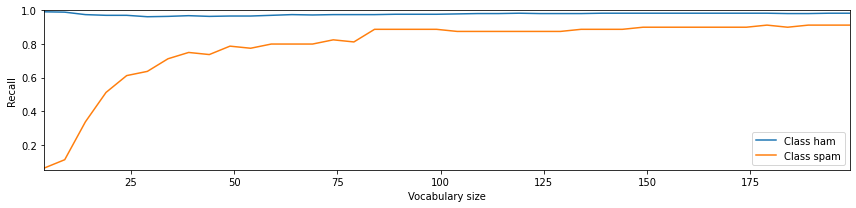

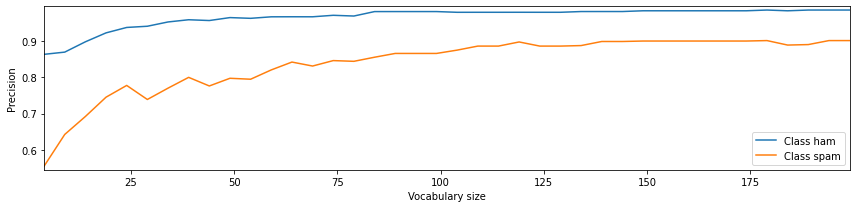

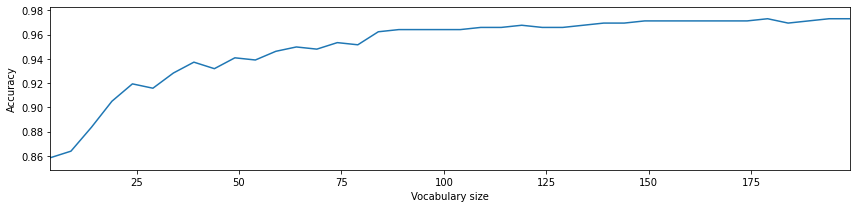

In [83]:
plot_precision_recall(X_train, y_train, X_test, y_test, BoW)

### Задание 3 (2 балла)
Теперь добавим в BoW стемминг. Для этого нам понадобится класс SnowballStemmer из пакета `nltk`

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [102]:
class BowStem:
    def __init__(self, X: np.ndarray, voc_limit: int = 1000):
        """
        Составляет словарь, который будет использоваться для векторизации предложений.

        Parameters
        ----------
        X : np.ndarray
            Массив строк (предложений) размерности (n_sentences, ), 
            по которому будет составляться словарь.
        voc_limit : int
            Максимальное число слов в словаре.

        """

        self.voc_limit = voc_limit
        self.vocabulary = self._create_vocab(X)
        self.v_encoding = {v: k for k, v in enumerate(self.vocabulary)}


    def _sentence_preprocessing(self, sentence) -> list:
        stemmer = SnowballStemmer("english")
        sentence = sentence.translate(str.maketrans('', '', punctuation)).split()
        return [stemmer.stem(word) for word in sentence]


    def _create_vocab(self, X: np.ndarray) -> np.ndarray:
      sentences = []
      for sentence in X:
          sentences.extend(self._sentence_preprocessing(sentence))
      sentences = np.array(sentences)
      vocabulary, word_freq = np.unique(sentences, return_counts=True)
      return vocabulary[(-word_freq).argsort()][:self.voc_limit]

        
    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Векторизует предложения.

        Parameters
        ----------
        X : np.ndarray
            Массив строк (предложений) размерности (n_sentences, ),
            который необходимо векторизовать.

        Return
        ------
        np.ndarray
            Матрица векторизованных предложений размерности
            (n_sentences, vocab_size)
        """
        n_sentences = X.shape[0]
        X_bow = np.zeros((n_sentences, self.voc_limit), dtype=int)
        for i, sentence in enumerate(X):
            sentence = self._sentence_preprocessing(sentence)
            row = np.zeros(self.voc_limit, dtype=int)
            for word in sentence:
                try:
                    idx = self.v_encoding[word]
                    row[idx] += 1
                except:
                    continue
            X_bow[i, :] = row.copy()
        return X_bow

In [103]:
bows = BowStem(X_train, voc_limit=500)
X_train_bows = bows.transform(X_train)
X_test_bows = bows.transform(X_test)

In [104]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bows, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bows), y_test)

({'ham': 0.9857723577235772, 'spam': 0.9242424242424242},
 {'ham': 0.9897959183673469, 'spam': 0.8970588235294118},
 0.978494623655914)

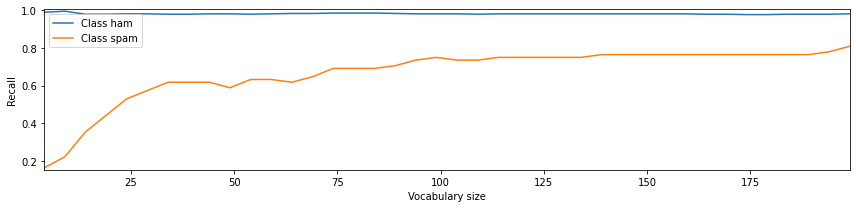

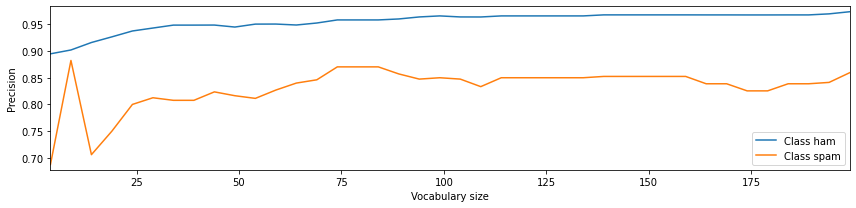

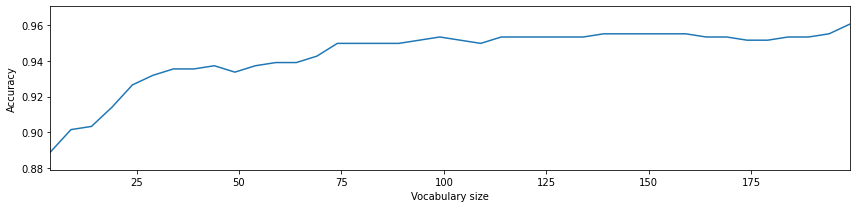

In [105]:
plot_precision_recall(X_train, y_train, X_test, y_test, BowStem)